Импорт библиотек

In [521]:
import pandas as pd
import requests
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt

Прочитаем значения переменных окружения

In [523]:
load_dotenv() # загружаются переменные из файла

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END   = os.getenv('DATE_END')
API_URL    = os.getenv('API_URL')

Запрос данных по визитам

In [525]:
l_requests_visits = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
l_df_api_visits = pd.DataFrame.from_dict(l_requests_visits.json())

Запрос данных по регистрациям

In [527]:
l_requests_regs = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
l_df_api_regs = pd.DataFrame.from_dict(l_requests_regs.json())

Отфильтруем ботов

In [529]:
l_df_api_visits['bot'] = l_df_api_visits['user_agent'].str.contains('bot')
l_df_api_visits = l_df_api_visits[~l_df_api_visits['bot']]

Оставим только последние посещения для каждого пользователя

In [531]:
l_df_api_last_visit = l_df_api_visits.groupby(['visit_id']).agg({'datetime': 'max'})
l_df_api_visits = pd.merge(l_df_api_visits, l_df_api_last_visit, on=['visit_id', 'datetime'], how='inner')

Рассчитаем поле с датой в формате Unix

In [533]:
l_df_api_visits['date'] = l_df_api_visits['datetime'].str.slice(stop=10)
l_df_visits_4_visual = l_df_api_visits
l_df_api_visits['date_group'] = pd.to_datetime(l_df_api_visits['date']).astype('int64').astype(str).str.slice(stop=13).astype('int64')

Удаление дубликатов и сортировка

In [535]:
l_df_api_visits = l_df_api_visits[['date_group', 'platform', 'visit_id']]
l_df_api_visits.drop_duplicates(inplace=True)
l_df_api_visits.sort_values(['date_group','platform'], ascending=[True, True], inplace=True)

C:\Users\dvpusev\AppData\Local\Temp\ipykernel_23348\3626328730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l_df_api_visits.drop_duplicates(inplace=True)
C:\Users\dvpusev\AppData\Local\Temp\ipykernel_23348\3626328730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l_df_api_visits.sort_values(['date_group','platform'], ascending=[True, True], inplace=True)


Сагрегируем таблицу визитов по датам посещений и платформам

In [537]:
l_df_api_visits_agg = l_df_api_visits.groupby(['date_group', 'platform']).agg('count')
l_df_api_visits_agg.reset_index(inplace=True)
l_df_api_visits_agg.rename(columns={'visit_id': 'visits'}, inplace=True)

Рассчитаем поле с датой в формате Unix

In [539]:
l_df_api_regs['date'] = l_df_api_regs['datetime'].str.slice(stop=10)
l_df_regs_4_visual = l_df_api_regs
l_df_api_regs['date_group'] = pd.to_datetime(l_df_api_regs['date']).astype('int64').astype(str).str.slice(stop=13).astype('int64')

Удалим дубликаты

In [541]:
l_df_api_regs = l_df_api_regs[['date_group', 'platform', 'user_id']]
l_df_api_regs.drop_duplicates(inplace=True)

C:\Users\dvpusev\AppData\Local\Temp\ipykernel_23348\538284114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l_df_api_regs.drop_duplicates(inplace=True)


Сагрегируем таблицу регистраций по датам посещений и платформам

In [543]:
l_df_api_regs_agg = l_df_api_regs.groupby(['date_group', 'platform']).agg('count')
l_df_api_regs_agg.reset_index(inplace=True)
l_df_api_regs_agg.rename(columns={'user_id': 'registrations'}, inplace=True)

Объединим таблицы посещений и регистраций. Рассчитаем конверсию.

In [545]:
l_df_conversion = pd.merge(l_df_api_visits_agg, l_df_api_regs_agg, on=['date_group', 'platform'], how='outer')
l_df_conversion['conversion'] = round(l_df_conversion['registrations'] / l_df_conversion['visits'] * 100, 10)
l_df_conversion.sort_values(['date_group', 'platform'], ascending=[True, True], inplace=True)
l_df_conversion.reset_index(drop=True, inplace=True)
l_df_conversion.to_json('./conversion.json')

Прочитаем данные о рекламных кампаниях

In [547]:
l_df_ads = pd.read_csv('./ads.csv')

Рассчитаем поле с датой и агрегируем таблицу

In [549]:
l_df_ads['date'] = l_df_ads['date'].str.slice(stop=10)
l_df_ads = l_df_ads[l_df_ads['date'] < DATE_END]
l_df_ads_4_visual = l_df_ads
l_df_ads['date_group'] = pd.to_datetime(l_df_ads['date']).astype('int64').astype(str).str.slice(stop=13).astype('int64')
l_df_ads_agg_2 = l_df_ads.groupby(['date_group', 'utm_campaign']).agg({'cost': 'sum'})
l_df_ads_agg_2.reset_index(inplace=True)

Ещё больше агрегируем таблицы визитов и регистраций (поле platform больше не нужно)

In [551]:
l_df_api_visits_agg_2 = l_df_api_visits_agg.groupby('date_group').agg({'visits': 'sum'})
l_df_api_regs_agg_2 = l_df_api_regs_agg.groupby('date_group').agg({'registrations': 'sum'})

Рассчитываем таблицу с зарплатами на рекламу

In [553]:
l_df_merge_ads_1 = pd.merge(l_df_api_visits_agg_2, l_df_api_regs_agg_2, on=['date_group'], how='outer')
l_df_merge_ads_1.reset_index(inplace=True)
l_df_merge_ads_2 = pd.merge(l_df_merge_ads_1, l_df_ads_agg_2, on=['date_group'], how='outer')
l_df_ads_2 = l_df_merge_ads_2[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
l_df_ads_2.fillna({'cost': 0, 'utm_campaign': 'None'}, inplace=True)
l_df_ads_2.sort_values(['date_group'], ascending=[True], inplace=True)
l_df_ads_2.reset_index(drop=True, inplace=True)
l_df_ads_2.to_json('./ads.json')

Создаем директорию Charts

In [616]:
path = './charts'
if not os.path.exists(path):
    os.mkdir(path)

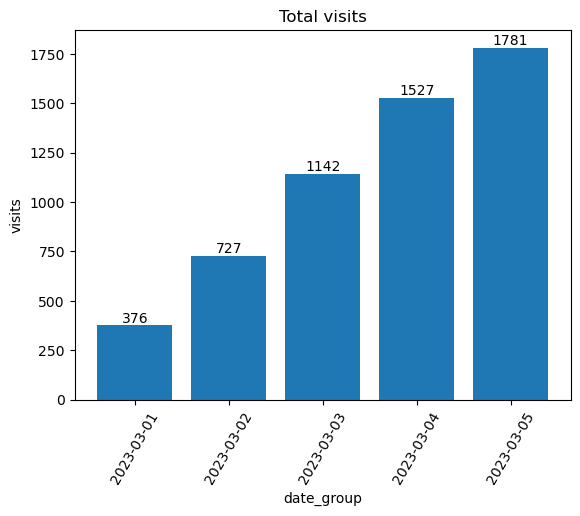

In [618]:
l_df_visual_visits= l_df_visits_4_visual.groupby(['date']).agg({'visit_id': 'count'})
l_df_visual_visits.reset_index(inplace=True)
visit_bar = plt.bar(l_df_visual_visits['date'], l_df_visual_visits['visit_id'])
plt.title('Total visits')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.xticks(rotation = 60)
plt.bar_label(visit_bar)
plt.savefig('./charts/visits.png')